# XSBench
## Parameters
```
Compiler = 'clang 5.0.1'
Build_Flags = '-g -O3 -march=native -fopenmp -lm'
Run_Flags = '-t <# of threads> -l 30000000'
```

---
## Scaling

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

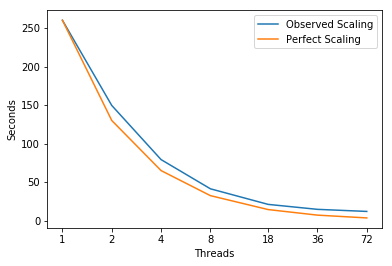

In [4]:
# Plot Measurements
Threads = [1,2,4,8,18,36,72]
fig, ax = plt.subplots(); ax.set_xscale('log', basex=2); ax.set_xticks(Threads)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.plot(Threads, [260.0, 149.5, 79.25, 41.375, 21.166666666666668, 14.722222222222221, 12.027777777777779],
        label='Observed Scaling')
ax.plot(Threads, [260.0, 130.0, 65.0, 32.5, 14.444444444444445, 7.222222222222222, 3.611111111111111],
        label='Perfect Scaling')
ax.legend(); ax.set_xlabel('Threads'); ax.set_ylabel('Seconds')
plt.show()

---
## Roofline - Intel Haswell - 72 Threads - 36 Cores - 2 Sockets - 2301.0 Mhz
| GB/sec | L1 B/W | L2 B/W | L3 B/W | DRAM B/W |
|:---------|:------:|:------:|:------:|:--------:|
| **1 Thread**   | 142.7  |  45.0  |  33.7  |   16.0   |
|**72 Threads**  | 2399.9  |  784.0  |  564.8  |   60.4  |

---
## Program Aggregate
| Experiment Aggregate Metrics | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-----------------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                            |  100.0 %   |       0.67          |        27.2% |         89.0% |     12.2% |                0.11     |       14.7% |       17.5%  |       4.5%    |
| 72                           |  100.0 %   |       0.42          |        27.2% |         92.0% |     11.6% |                0.06     |       17.6% |       22.5%  |      24.3%    |

---
## binary_search ( )
| binary_search | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:--------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1             |  63.3 %   |       0.79          |        57.2% |         89.2% |      0.0% |                0.04     |       17.9% |       21.3%  |       0.0%    |
| 72            |  32.7 %   |       0.85          |        75.8% |         92.8% |      0.0% |                0.02     |       41.9% |       54.0%  |       0.0%    |
```c
|44|// Binary Search function for nuclide grid
|45|// Returns ptr to energy less than the quarry that is closest to the quarry
|46|int binary_search( NuclideGridPoint * A, double quarry, int n )
|47|{       
|48|	int min = 0;
|49|	int max = n-1;
|50|	int mid;
|51|	
|52|	// checks to ensure we're not reading off the end of the grid
|53|	if( A[0].energy > quarry )                          
|54|		return 0;
|55|	else if( A[n-1].energy < quarry )
|56|		return n-2;
|57|
|58|	// Begins binary search	
|59|	while( max >= min )
|60|	{    
|61|        	mid = min + floor( (max-min) / 2.0);
|62|		if( A[mid].energy < quarry )   
|63|			min = mid+1;
|64|		else if( A[mid].energy > quarry )
|65|			max = mid-1;
|66|		else
|67|			return mid;
|68|	}
|69|       	return max;
|70|}
```


---
## calculate_micro_xs ( )
| calculate_micro_xs | CPUTIME % | Inst/Cycle per Core | L1 DC Miss % | L2 DC Miss %  | L3 Miss % | L1 Loads/Cycle per Core | L2 B/W Used | L3 B/W Used  | DRAM B/W Used |
|:-------------------|:---------:|:-------------------:|:------------:|:-------------:|:---------:|:-----------------------:|:-----------:|:------------:|:-------------:|
| 1                  |  22.2 %   |       0.42          |         6.7% |         98.6% |     77.7% |                0.27     |        8.0% |       10.6%  |      17.3%    |
| 72                 |  54.2 %   |       0.12          |         9.6% |         93.8% |     68.8% |                0.05     |        4.9% |        6.4%  |      41.1%    |
```c
  3 // Calculates the microscopic cross section for a given nuclide & energy
  4 void calculate_micro_xs(   double p_energy, int nuc, long n_isotopes,
  5                            long n_gridpoints,
  6                            GridPoint * restrict energy_grid,
  7                            NuclideGridPoint ** restrict nuclide_grids,
  8                            long idx, double * restrict xs_vector, int grid_type ){
  9 
 10         // Variables
 11         double f;
 12         NuclideGridPoint * low, * high;
 13 
 14         // If using only the nuclide grid, we must perform a binary search
 15         // to find the energy location in this particular nuclide's grid.
 16         if( grid_type == NUCLIDE )
 17         {
 18                 // Perform binary search on the Nuclide Grid to find the index
 19                 idx = grid_search_nuclide( n_gridpoints, p_energy, nuclide_grids[nuc]);
 20 
 21                 // pull ptr from nuclide grid and check to ensure that
 22                 // we're not reading off the end of the nuclide's grid
 23                 if( idx == n_gridpoints - 1 )
 24                         low = &nuclide_grids[nuc][idx - 1];
 25                 else
 26                         low = &nuclide_grids[nuc][idx];
 27         }
 28         else // Unionized Energy Grid - we already know the index, no binary search needed.
 29         {
 30                 // pull ptr from energy grid and check to ensure that
 31                 // we're not reading off the end of the nuclide's grid
 32                 if( energy_grid[idx].xs_ptrs[nuc] == n_gridpoints - 1 )
 33                         low = &nuclide_grids[nuc][energy_grid[idx].xs_ptrs[nuc] - 1];
 34                 else
 35                         low = &nuclide_grids[nuc][energy_grid[idx].xs_ptrs[nuc]];
 36         }
 37 
 38         high = low + 1;
 39 
 40         // calculate the re-useable interpolation factor
 41         f = (high->energy - p_energy) / (high->energy - low->energy);
 42 
 43         // Total XS
 44         xs_vector[0] = high->total_xs - f * (high->total_xs - low->total_xs);
 45 
 46         // Elastic XS
 47         xs_vector[1] = high->elastic_xs - f * (high->elastic_xs - low->elastic_xs);
 48 
 49         // Absorbtion XS
 50         xs_vector[2] = high->absorbtion_xs - f * (high->absorbtion_xs - low->absorbtion_xs);
 51 
 52         // Fission XS
 53         xs_vector[3] = high->fission_xs - f * (high->fission_xs - low->fission_xs);
 54 
 55         // Nu Fission XS
 56         xs_vector[4] = high->nu_fission_xs - f * (high->nu_fission_xs - low->nu_fission_xs);
            (...)
 69 }
```